## This is an example for doing 1D loop extrusion simulations 

The class is designed to be very flexible and easy to modify. It provides several small tools to make efficient simulations, and shows how to deal with LEF states, with two legs, etc. 



In [7]:
import numpy as np
import pandas as pd
import h5py 

class leg(object):
    def __init__(self, pos, attrs={"stalled":False, "CTCF":False}):
        """
        A leg has two important attribues: pos (positions) and attrs (a custom list of attributes)
        """
        self.pos = pos
        self.attrs = dict(attrs)

class cohesin(object):
    """
    A cohesin class provides fast access to attributes and positions 
    
    
    cohesin.left is a left leg of cohesin, cohesin.right is a right leg
    cohesin[-1] is also a left leg and cohesin[1] is a right leg         
    
    Also, cohesin.any("myattr") is True if myattr==True in at least one leg
    cohesin.all("myattr") is if myattr=True in both legs
    """
    def __init__(self, leg1, leg2):
        self.left = leg1
        self.right = leg2
   
    def any(self, attr):
        return self.left.attrs[attr] or self.right.attrs[attr]
    
    def all(self, attr):
        return self.left.attrs[attr] and self.right.attrs[attr]    
    
    def __getitem__(self, item):
        if item == -1:
            return self.left
        elif item == 1:
            return self.right 
        else:
            raise ValueError()
        

def unloadProb(cohesin, args):
    """
    Defines unload probability based on a state of cohesin 
    """
    if cohesin.any("stalled"):
        # if one side is stalled, we have different unloading probability 
        # Note that here we define stalled cohesins as those stalled not at CTCFs 
        return 1 / args["LIFETIME_STALLED"]
    # otherwise we are just simply unloading 
    return 1 / args["LIFETIME"]    
    


def loadOne(cohesins, occupied, args): 
    """
    A function to load one cohesin 
    """
    while True:
        a = np.random.randint(args["N"])
        if (occupied[a] == 0) and (occupied[a+1] == 0):
            occupied[a] = 1
            occupied[a+1] = 1 
            cohesins.append(cohesin(leg(a), leg(a+1)))
            break


def capture(cohesin, occupied, args):
    """
    We are describing CTCF capture here. 
    This function is specific to this particular project, and 
    users are encouraged to write functions like this 
    
    Note the for-loop over left/right sites below, and using cohesin[side] 
    to get left/right leg. 
    
    Also note how I made ctcfCapture a dict with -1 coding for left side, and 1 for right side 
    and ctcfCapture are dicts as well: keys are locations, and values are probabilities of capture
    """    
    for side in [1, -1]:
        # get probability of capture or otherwise it is 0 
        if np.random.random() < args["ctcfCapture"][side].get(cohesin[side].pos, 0):  
            cohesin[side].attrs["CTCF"] = True  # captured a cohesin at CTCF     
    return cohesin 


def release(cohesin, occupied, args):
    
    """
    AN opposite to capture - releasing cohesins from CTCF 
    """
    
    if not cohesin.any("CTCF"):
        return cohesin  # no CTCF: no release necessary 
        
    # attempting to release either side 
    for side in [-1, 1]: 
        if (np.random.random() < args["ctcfRelease"][side].get(cohesin[side].pos, 0)) and (cohesin[side].attrs["CTCF"]):
            cohesin[side].attrs["CTCF"] = False 
    return cohesin 


def translocate(cohesins, occupied, args):
    """
    This function describes everything that happens with cohesins - 
    loading/unloading them and stalling against each other 
    
    It relies on the functions defined above: unload probability, capture/release. 
    """
    # first we try to unload cohesins and free the matching occupied sites 
    for i in range(len(cohesins)):
        prob = unloadProb(cohesins[i], args)
        if np.random.random() < prob:
            occupied[cohesins[i].left.pos] = 0 
            occupied[cohesins[i].right.pos] = 0 
            del cohesins[i]
            loadOne(cohesins, occupied, args)
    
    # then we try to capture and release them by CTCF sites 
    for i in range(len(cohesins)):
        cohesins[i] = capture(cohesins[i], occupied, args)
        cohesins[i] = release(cohesins[i], occupied, args)
    
    # finally we translocate, and mark stalled cohesins because 
    # the unloadProb needs this 
    for i in range(len(cohesins)):
        cohesin = cohesins[i] 
        for leg in [-1,1]: 
            if not cohesin[leg].attrs["CTCF"]: 
                # cohesins that are not at CTCFs and cannot move are labeled as stalled 
                if occupied[cohesin[leg].pos  + leg] != 0:
                    cohesin[leg].attrs["stalled"] = True
                else:
                    cohesin[leg].attrs["stalled"] = False 
                    occupied[cohesin[leg].pos] = 0
                    occupied[cohesin[leg].pos + leg] = 1
                    cohesin[leg].pos += leg        
        cohesins[i] = cohesin
        
def color(cohesins, args):
    "A helper function that converts a list of cohesins to an array colored by cohesin state"    
    def state(attrs):
        if attrs["stalled"]:
            return 2
        if attrs["CTCF"]:
            return 3
        return 1
    ar = np.zeros(args["N"])
    for i in cohesins:
        ar[i.left.pos] = state(i.left.attrs)
        ar[i.right.pos] = state(i.right.attrs)  
    return ar 

## A toy simulation with two cohesins and 2 CTF sites 

<IPython.core.display.Javascript object>


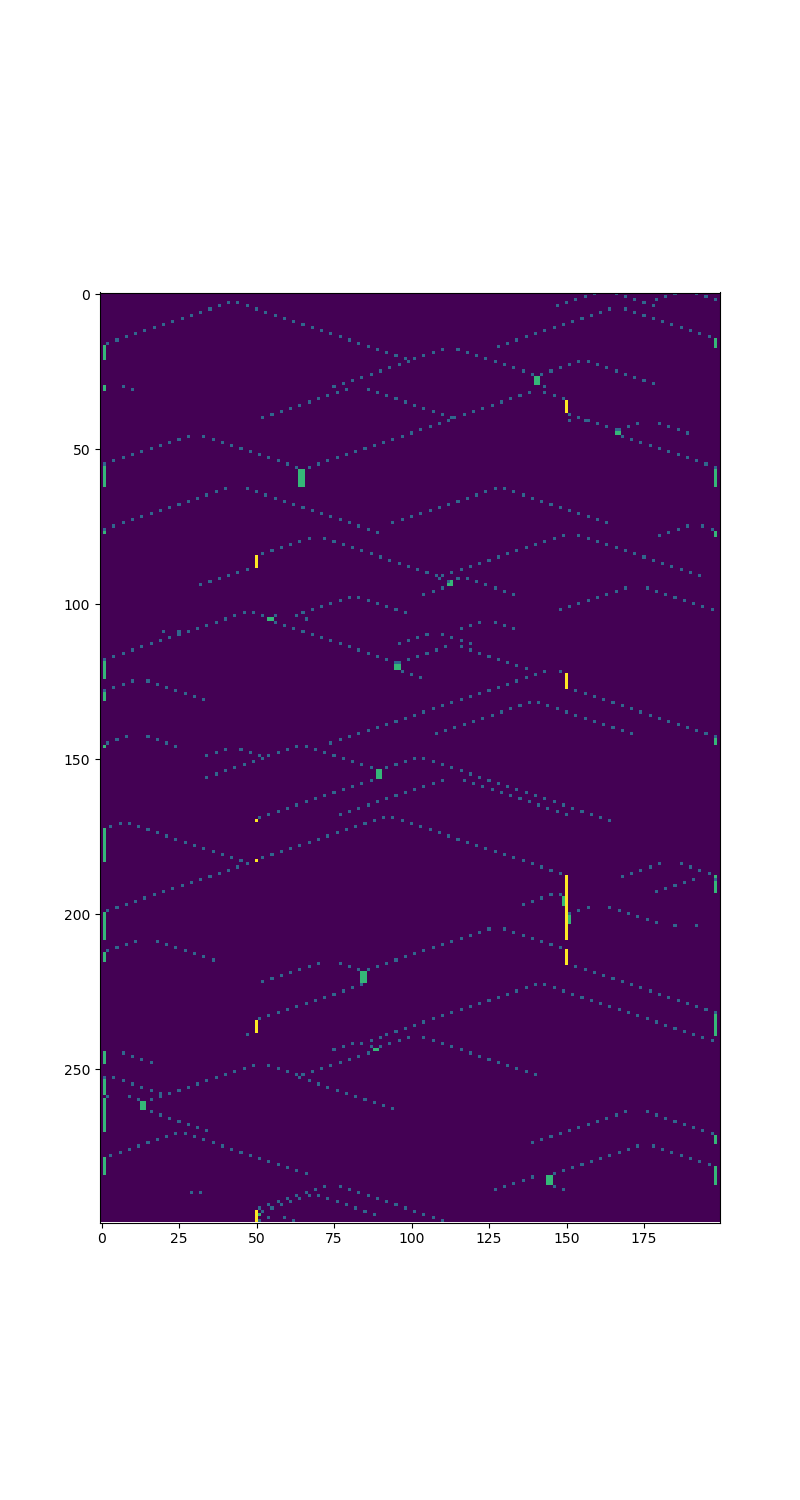

In [9]:
SMCs = 2
args = {}
N = 200    # two SMCs in a 200-monomer long simulation 

ctcfLeftCapture = {50:0.5}  # at position 50 we have a CTCF that  travelling left with 50% prob
ctcfRightCapture = {150:0.5}  # and at 150 - those travelling right 
ctcfLeftRelease = {50:0.02}     # and we release them with 0.02 probability each step (on average 50 step residence time)
ctcfRightRelease = {150:0.02}  

args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}  # this is how we feed the dictionaries of capture/release probabilities to our code 
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = 100
args["LIFETIME_STALLED"] = 10 # in this code, if you are stalled, you have 10 times lower lifetime 
# but if you are stalled at CTCF, you don't 
# try to find this in the image below and verify that it works

occupied = np.zeros(N)
occupied[0] = 1
occupied[-1] = 1 
cohesins = []

for i in range(SMCs):
    loadOne(cohesins,occupied, args)

pos = []
for i in range(300):
    for _ in range(3):
        translocate(cohesins, occupied, args)
    pos.append(color(cohesins, args))
    
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,15))
plt.imshow(np.array(pos))

## This will be a full-scale simulation, but we're going to visualize some trajectory first 

<IPython.core.display.Javascript object>


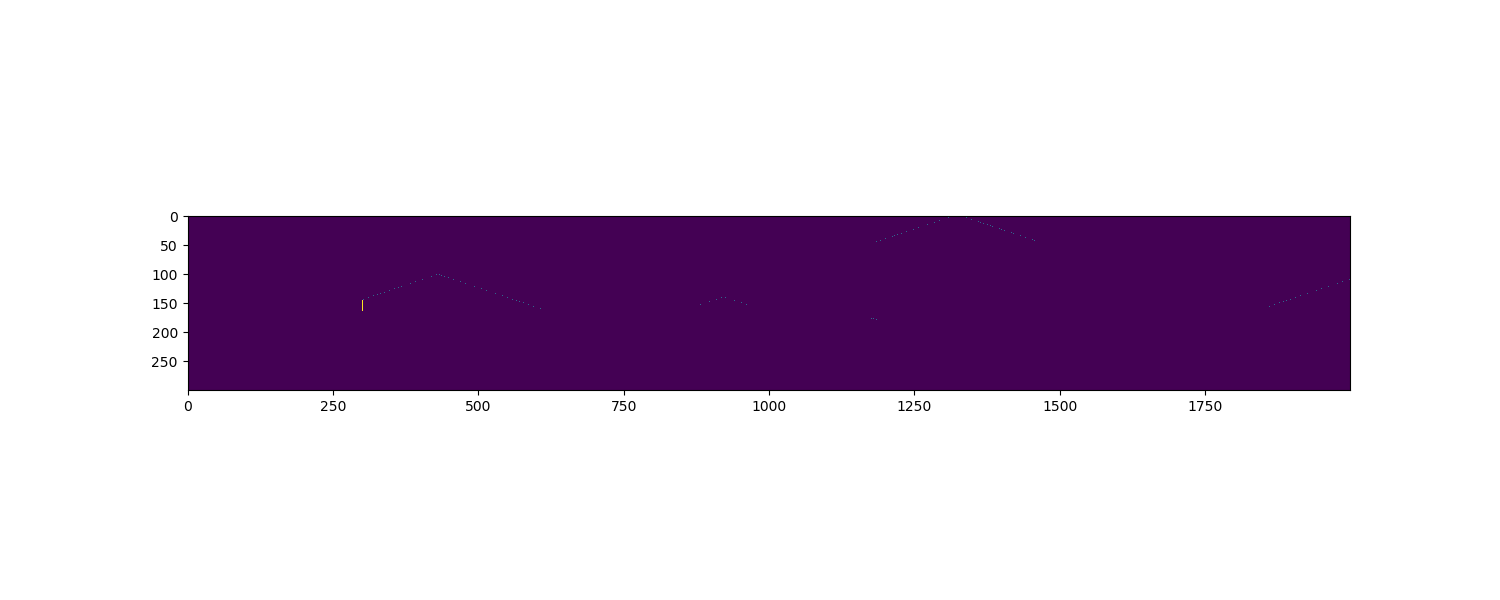

In [3]:
"""
Now building the real system and testing that it works (displaying the first 2000 monomers out of 40,000)
"""

N1 = 4000 # size of one system 
M = 10 
N = N1 * M 

LIFETIME = 200 
SEPARATION = 200
LEFNum = N1 // SEPARATION 
trajectoryLength = 100000

TADs = [300,800,1500,2300,2900,3400]

ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

for i in range(M):
    for tad in TADs:
        pos = i * N1 + tad 
        ctcfLeftCapture[pos] = 0.9  # 80% capture probability 
        ctcfLeftRelease[pos] = 0.003  # hold it for ~300 blocks on average
        ctcfRightCapture[pos] = 0.9
        ctcfRightRelease[pos] = 0.003
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1
occupied[-1] = 1 

cohesins = []
for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

pos = []
for i in range(300):
    for _ in range(3):
        translocate(cohesins, occupied, args)
    pos.append(color(cohesins, args))
    
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,6))
plt.imshow(np.array(pos)[:, :2000])

## Doing actual simulation now - saving a trajectory

In [4]:
occupied = np.zeros(N)
occupied[0] = 1
occupied[-1] = 1 
cohesins = []

for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

with h5py.File("trajectory/LEFPositions.h5", mode='w') as myfile:
    
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 50    # saving in 50 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    for st,end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            translocate(cohesins, occupied, args)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum


